**Import necessary packages for the following project**

In [1]:
import numpy as np

import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate

import sympy as sm
from sympy import lambdify

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import ipywidgets as widgets
from ipywidgets import interact, fixed

sm.init_printing(use_unicode=True)

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1: Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital).** 

We start by defining the utility and value function for period 2 as follows:

In [4]:
def utility(c,rho):
    """
    Generates the main part of the utility function regarding consumption in current period
    
    Args:
        c (float): consumption in current period
        rho (float): Coefficient of relative risk aversion  
        
    Returns:
        utility (float) gained from consumption and wrt. relative risk aversion
    """
    return c**(1-rho)/(1-rho)

def v2(w,h2,rho,gamma,l2,b):
    """
    Generates the full utility function for the second period of the model
    
    Args:
        w (float): Wage level
        h2 (float): Human capital level in second period
        rho (float): Coefficient of relative risk aversion
        gamma (float): Degree to which labor creates disutility
        l2 (boolean): Dummy for whether the consumer works (1) or not (0)
        b (float): The unemployment benefit level 
        
    Returns:
        net utility (float) gained in the second period
    """
    if l2==0:
        c2 = b
    else:
        c2 = w*h2
    return utility(c2,rho)-gamma*l2

We now find what value $h_2$ needs to have, so that the person wants to work. This we do by looking at for what value of $h_2$ the difference between the two value functions, where $l_2=0$ and where $l_2=1$, is lowest. 

In [5]:
def find_h2(rho,gamma,w,b):
    """
    Finds the threshold value for h_2 where the consumer will be indifferent between working or not. 
    This is done by minimizing the absolute difference between the utility function with l_2=1 and l_2=0.  
    
    Args:
        rho (float): Coefficient of relative risk aversion 
        gamma (float): Degree to which labor creates disutility 
        w (float): Wage level
        b (float): The unemployment benefit level 
        
    Returns:
        result (float) which is the threshold value of h_2
    """
    diff = lambda h2: abs(v2(w,h2,rho,gamma,1,b)-v2(w,h2,rho,gamma,0,b))
    guess = 0
    result = optimize.minimize_scalar(diff,guess,method='bounded',bounds=[0,10])
    return result

In [6]:
h2_threshold = find_h2(rho,gamma,w,b).x
h2_threshold

We see that this is when $h_2=0.556$, which seems like a reasonable level compared to the relevant levels of human capital given by h_vec. For this exact value of human capital, the consumer is indifferent between working or not working in this case. 

Given this threshold value of $h_2$ we can now plot the simple graph of the labor that is supplied in period 2 as follows:

In [7]:
def labor_supply_period2(h2_threshold,h_vec):
    """
    Creates a vector of 1's and 0's for the different values in h_vec. 
    Takes the value 0 if h_vec[i] is below value h2_threshold and 1 if above.
    
    Args:
        h2_threshold (float): Threshold level for which consumer is indifferent between working or not
        h_vec (numpy.ndarray): Spans the possible values of h. 
        
    Returns:
        l2_supply (list) which contains when consumer will work based on values of h_vec and h2_threshold.
    """
    l2_supply=[]
    
    for i in h_vec*10:
        if i/10 < h2_threshold :
            l2_supply.append(0)
        else:
            l2_supply.append(1)
    return l2_supply

l2_graph = labor_supply_period2(h2_threshold,h_vec)

Text(0, 0.5, 'Labor supply in second period')

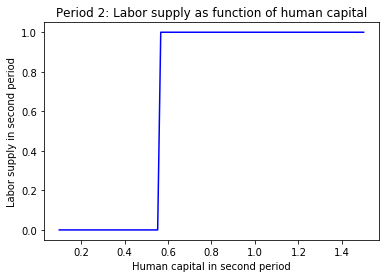

In [8]:
#Plot graph
plt.plot(h_vec,l2_graph, color='Blue')
plt.title("Period 2: Labor supply as function of human capital") #Adding title
plt.xlabel("Human capital in second period") #Labelling x-axis
plt.ylabel("Labor supply in second period") #Labelling y-axis

Here we see that the labor supply goes from 0 to 1 as soon as the human capital level in period 2 surpasses the threshold level of 0.556, as this ensures that the worker's utility is higher when working than when not working. 

To now finally find for how these factors impact the total utility of the worker, we set up the following function, to find the utility when working optimally, when never working and when always working. This gives:

In [9]:
def solve_period2(rho,gamma,Delta):
    """
    Creates three numpy.ndarrays that contains the utility gains in the second period, either if 
    working optimally, if not working at all or if working no matter what. 
    
    Args:
        rho (float): Coefficient of relative risk aversion
        gamma (float): Degree to which labor creates disutility 
        Delta (float): Positive shock to human capital
        
    Returns:
        v2_vec (numpy.ndarray) which contains utilities when working optimally wrt. human capital
        v2_vec_nowork (numpy.ndarray) which contains utilities when never working for different levels of human capital
        v2_vec_work (numpy.ndarray) which contains utilities when always working for different levels of human capital
    """    
    
    #Initialize lists
    v2_vec = np.empty(100)
    v2_vec_nowork = np.empty(100)
    v2_vec_work = np.empty(100)
    
    # Solve for each h2
    for i,h2 in enumerate(h_vec):
        
        v2_vec[i] = v2(w,h2,rho,gamma,l2_graph[i],b)
        v2_vec_nowork[i] = v2(w,h2,rho,gamma,0,b)
        v2_vec_work[i] = v2(w,h2,rho,gamma,1,b)
        
    return v2_vec, v2_vec_nowork, v2_vec_work

v2_vec,v2_vec_nowork,v2_vec_work = solve_period2(rho,gamma,Delta)

Plotting these three functions, we get:

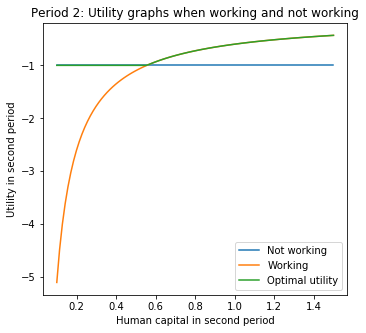

In [10]:
#Setting up figure
fig = plt.figure(figsize=(12,5))
graph1 = fig.add_subplot(1,2,1)

#Plotting utility graph for no work
graph1.plot(h_vec,v2_vec_nowork, label='Not working')

#Plotting utility graph for always work
graph1.plot(h_vec,v2_vec_work, label='Working')

#Plotting utility graph for optimal working 
graph1.plot(h_vec,v2_vec, label='Optimal utility')

#Adding titles, axis-names and labels
plt.title("Period 2: Utility graphs when working and not working")
plt.xlabel("Human capital in second period")
plt.ylabel("Utility in second period")
graph1.legend(loc='lower right')

Once again it is evident from this graph, that the threshold value of $h_2$ is around 0.56, as the utility graph when working crosses the utility graph of not working in this exact value. It is clear, that it is optimal for the consumer to not work when human capital levels are lower than this level, as they are ensured the unemployment benefit of $b$ and not compensated enough through the wages to start working. When $h_2$ rises the amount the consumer can consume rises as well, and when it reaches the threshold level, this compensation through the rise in consumption outweighs the disutility of working. 

**Question 2: Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).** 

To solve the model in period 1, we first have to the value function for period 1, which we define as seen below:

In [11]:
def v1(w,h1,rho,gamma,l1,b,beta,v2_interp,Delta):
    """
    Finds the net utility for period 1.
    
    Args:
        w (float): Coefficient of relative risk aversion
        h1 (float): Human capital realised in first period
        rho (float): Coefficient of relative risk aversion
        gamma (float): Degree to which labor creates disutility  
        l1 (boolean): Labor supplied in first period. Takes value 1 if labor is supplied and 0 if not. 
        b (float): Size of unemployment benefits
        beta (float): Degree to which expected utility in next period affects utility in this period
        v2_interp (scipy.interpolate.interpolate.RegularGridInterpolator): Values of h interpolated in the v2 function
        Delta (float): Positive shock to human capital
        
    Returns:
        net utility (list,float) net utility gained in period 1 
    """   
    #h_2 and v_2 if Delta = 0
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])
    
    #h_2 and v_2 if Delta = 1
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])
    
    #Finding expected v2
    v2 = 0.5*v2_low + 0.5*v2_high
    
    #Defining c1 based on l1
    if l1==0:
        c1 = b
    else:
        c1 = w*h1
    
    return utility(c1,rho) - gamma*l1 + beta*v2


To now get the vectors of the value function as well as the labor supply function wrt. human capital in period 1, we set up the following function, that creates a number of vectors containing labor supply and utility for different values of human capital:

In [12]:
def solve_period1(rho,gamma,beta,v2_interp,Delta,w,b):
    """
    Finds the net utility for period 1.
    
    Args:
        rho (float): Coefficient of relative risk aversion
        gamma (float): Degree to which labor creates disutility  
        beta (float): Degree to which expected utility in next period affects utility in this period
        v2_interp (scipy.interpolate.interpolate.RegularGridInterpolator): Values of h interpolated in the v2 function
        Delta (float): Positive shock to human capital
        w (float): Coefficient of relative risk aversion
        b (float): Size of unemployment benefits
        
    Returns:
        l1_vec (numpy.ndarray) list of when she will work in period 1 based on values of h1
        v1_vec (numpy.ndarray) list of utilities for each h if she works optimally
        v1_vec_nowork (numpy.ndarray) list of utilities for each h if she never works
        v1_vec_work (numpy.ndarray) list of utilities for each h if she always works
    """   
    
    #Initialize lists
    l1_vec = np.empty(100)
    v1_vec = np.empty(100)
    v1_vec_nowork = np.empty(100)
    v1_vec_work = np.empty(100)
    
    #Solve for each h1
    for i,h1 in enumerate(h_vec):
        if v1(w,h1,rho,gamma,1,b,beta,v2_interp,Delta) < v1(w,h1,rho,gamma,0,b,beta,v2_interp,Delta):
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
            
        v1_vec[i] = v1(w,h1,rho,gamma,l1_vec[i],b,beta,v2_interp,Delta)
        v1_vec_nowork[i] = v1(w,h1,rho,gamma,0,b,beta,v2_interp,Delta)
        v1_vec_work[i] = v1(w,h1,rho,gamma,1,b,beta,v2_interp,Delta) 
    
    return l1_vec, v1_vec, v1_vec_nowork, v1_vec_work


To use this function, we need to interpolate the values of h_vec in the v2_vec, which is done below. After this we define our different vectors from the function, and start by plotting the labor supply in the first period wrt. human capital. 

Text(0, 0.5, 'Labor supply in first period')

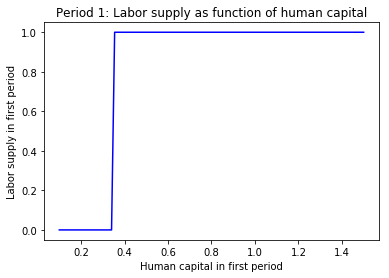

In [13]:
#Interpoltate
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec, bounds_error=False, fill_value=None)
#Define vectors
l1_vec,v1_vec,v1_vec_nowork,v1_vec_work=solve_period1(rho,gamma,beta,v2_interp,Delta,w,b)

#Plot labor supply as function of human capital
plt.plot(h_vec,l1_vec, color='Blue')
plt.title("Period 1: Labor supply as function of human capital") #Adding title
plt.xlabel("Human capital in first period") #Labelling x-axis
plt.ylabel("Labor supply in first period") #Labelling y-axis

We see from this graph, that labor is supplied for a lower value of $h$ than in the second period. This is due to the fact that the utility function for the second period is also included in the utility of the first period. Knowing that labor supplied in the first period affects the second period utility if working, the consumer has an extra incentive to work. 

Now to find the utilities of different options, which we plot below:

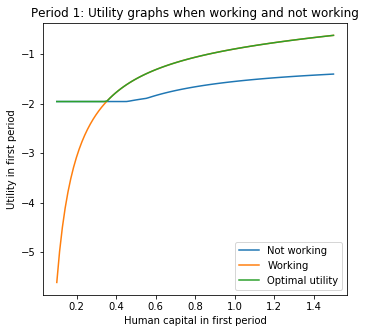

In [14]:
#Set up figure
fig = plt.figure(figsize=(12,5))
graph1 = fig.add_subplot(1,2,1)

#Add graph - utility when never work
graph1.plot(h_vec,v1_vec_nowork, label='Not working')

#Add graph - utility when always work
graph1.plot(h_vec,v1_vec_work, label='Working')

#Add graph - utility when work optimally
graph1.plot(h_vec,v1_vec, label='Optimal utility')

#Add titles and labels
plt.title("Period 1: Utility graphs when working and not working") #Adding title
plt.xlabel("Human capital in first period") #Labelling x-axis
plt.ylabel("Utility in first period") #Labelling y-axis
graph1.legend(loc='lower right')

To support the labor supply graph we saw earlier, we see that the consumer does maximize utility if she starts working for human capital levels of about 0.35 and above, and doesn't work if the levels are below this. Interestingly we see that the line that represents utility gained when not working begins to increase slightly for higher levels of $h$. This is due to the fact that with those high levels of $h$, the consumer is expected to work in the next period for those levels, whereas she will not work either with lower levels. 

**Question 3: Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.**

We now plot below the two graphs from Question 2 with sliders that allow one to adjust the values of the wage level, $w$, and the benefit level, $b$, as to analyse whether the worker will work in cases where her wage is lower than her benefits. 

In [15]:
def figure_widgets(w,b):
    """
    Function that plots two graphs of utility and labor wrt. human capital.
    For later use to add sliders for w (wages) and b (benefits).
    
    Args:
        w (float): Coefficient of relative risk aversion
        b (float): Size of unemployment benefits
        
    Returns:
        Two graphs
    """   
    
    #Redefine the vectors that are used in graphs
    l1_vec1,v1_vec1,v1_vec_nowork1,v1_vec_work1=solve_period1(rho,gamma,beta,v2_interp,Delta,w,b)
    
    #Set up figure
    fig = plt.figure(figsize=(12,5))
    
    #Plot graph 1
    graph1 = fig.add_subplot(1,2,1)
    graph1.plot(h_vec,v1_vec_nowork1, label='Not working')
    graph1.plot(h_vec,v1_vec_work1, label='Working')
    graph1.plot(h_vec,v1_vec1, label='Optimal utility')
    plt.title("Period 1: Utility graphs when working and not working") #Adding title
    plt.xlabel("Human capital in first period") #Labelling x-axis
    plt.ylabel("Utility in first period") #Labelling y-axis
    graph1.legend(loc='lower right')
    
    #Plot graph 2
    graph4 = fig.add_subplot(1,2,2)
    graph4.plot(h_vec,l1_vec1)
    plt.title("Period 1: Labor supply as function of human capital") #Adding title
    plt.xlabel("Human capital in first period") #Labelling x-axis
    plt.ylabel("Labor supply") #Labelling y-axis
    
#Printing plots and adding two sliders for b and w. 
widgets.interact(figure_widgets, b = widgets.FloatSlider(value=1, description='Benefits', min=0.1, max=5, step=0.1),
    w = widgets.FloatSlider(value=2, description='Wages', min=0.1,max=5, step=0.1))

interactive(children=(FloatSlider(value=2.0, description='Wages', max=5.0, min=0.1), FloatSlider(value=1.0, de…

<function __main__.figure_widgets(w, b)>

We can see from these graphs that she will actually still possibly want to work if her wages are below the benefits. However, it depends on the level of human capital. If the level of human capital is very low she wont work in the first period and won't expect to work in the second. The fact that she doesn't expect to work in the second period is evident from the "Not working"-graph that is completely vertical for values of the human capital where she doesn't expect to work in the next period either. So from these graphs we can see examples of both possibilites. Likewise, there are also cases where wages are higher than unemployment benefits, but where she will not work in any period (for low values of $h$). 

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [16]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1: Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.**

We start by defining the relevant variables and parameters from our model

In [17]:
y = sm.symbols('y_t')
y1 = sm.symbols('y_{t-1}')
alpha = sm.symbols('alpha')
v = sm.symbols('v_t')
h = sm.symbols('h')
pi = sm.symbols('\pi_t')
b = sm.symbols('b')
phi = sm.symbols('\phi')
pi1 = sm.symbols('\pi_{t-1}')
s = sm.symbols('s_t')
s1 = sm.symbols('s_{t-1}')
gamma = sm.symbols('\gamma')
y, y1, alpha, v, h, pi, b, phi, pi1, s, s1, gamma

And then we're checking whether they are correctly defined

In [18]:
y, y1, alpha, v, h, pi, b, phi, pi1, s, s1, gamma

We now define an display the equations for the AD- and SRAS-curve of the model

In [19]:
ADcurve = sm.Eq(pi,1/(h*alpha)*(v-(1+b*alpha)*y))
SRAScurve = sm.Eq(pi,pi1+gamma*y-phi*gamma*y1+s-phi*s1)
ADcurve, SRAScurve

We will find the equilibrium values of the output- and inflation gap by setting the AD- and SRAS-curve equal to each other and solving for the two variables, respectively

In [20]:
Equilibrium = sm.solve([ADcurve,SRAScurve], y, pi, dict=True)
Equilibrium = Equilibrium[0]

From the equilibrium values of the output- and the inflation-gap, respectively, we define lambda functions for each of them with all the variables and parameters as inputs and print the equilibrium values

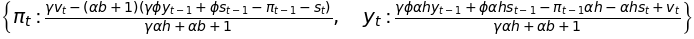

In [21]:
y_func=lambdify((v, y1, s, s1, pi1, alpha, h, b, phi, gamma),Equilibrium[y])
pi_func=lambdify((v, y1, s, s1, pi1, alpha, h, b, phi, gamma),Equilibrium[pi])

#Print
Equilibrium

The results above express the equilibrium values of the output- and inflation-gap from this model. 

We see that the output in the economy is positively related to the demand disturbance in period $t$, $v_t$: an increase in this variable increases the aggregate demand in the economy, and thus the output via an increase in the supply of the goods in the economy. On the other hand, in increase in the supply disturbance in period $t$, $s_t$, would *lower* the equilibrium output. That is because an increase in the supply disturbance will increase the costs for the suppliers and they will therefore increase the prices for their goods, ultimately resulting in fewer good being traded and a lower equilibrium output. Finally, we see that the equilibrium output depends positively on the output-gap from the previous period, $y_{t-1}$, thus implying some persistance in the economy.

From the result above we also observe the inflation-gap equilibrium. The intuition from this result is somewhat similar to that of the output equilibrium value. An increase in the demand disturbance increases the inflation-gap, as the buyers in the economy are now willing to pay a higher price for the same amount of goods. From the equilibrium output value we know that an increase in the supply disturbance would lower the outputgap, and from this result we observe that it will increase the inflation-gap. That is becuase the sellers of the economy are now forced to sell their goods at higher prices for a given amount of goods, thus resulting in fewer goods being traded at a higher price. 

In the code cells below we have inserted the parameter values given in this question to the equations for the output- and inflation-gap in equilibrium:

In [22]:
# Inserting the values of the parameters to obtain the output-gap in equilibrium including these values
Equilibrium_values_y_q1 = y_func(v, y1, s, s1, pi1, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
sm.Eq(y, Equilibrium_values_y_q1)

In [23]:
# Inserting the values of the parameters to obtain the output-gap in equilibrium including these values
Equilibrium_values_pi_q1 = pi_func(v, y1, s, s1, pi1, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
sm.Eq(pi, Equilibrium_values_pi_q1)

With $\phi=0$ we see that neither the output-gap nor the inflation-gap depends on the output-gap and the supply shock from the previous period, $y_{t-1}$ and $s_{t-1}$. The eqilibrium value of the output-gap is negatively related to the inflation-gap and the supply disturbance from the previous periods, as both of these variables increase the prices in the economy and thus lowers the output. On the contrary, the inflation-gap in equilibrium is positively affected by the inflation-gap and the supply disturbance from the previous period, as increases in those variables increase the price level in the economy and thus the output-gap in equilibrium. We see that the inflation-gap is more fragile to changes in those variables than the output-gap is (i.e. a 1% change in each of those variables implies a 0.95% change for the inflation-gap as opposed to -0.70% change for the output-gap. Finally, we observe that the demand disturbance positively affects both the output- and the inflation-gap, as an increase in the demand disturbance shifts the AD-curve upwards and thus results in a higher output and inflation in equilibrium.

**Question 2: Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.**

We define the parameter values, set all the intial values to zero and introduce a demand shock, v_shock:

In [24]:
#Define parameter values
par['delta'] = 0.80
par['omega'] = 0.15

#Set initial values
y1_q2 = 0 
pi1_q2 = 0 
v_q2 = 0 
s_q2 = 0 
s1_q2 = 0 

#Define size of shock
v_shock = 0.1

We use our lambda function of the output- and inflation-gap and insert the initival values of the economy along with the values of the parameters to find the equilibrium

In [25]:
y_q2 = y_func(v_q2, y1_q2, s_q2, s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
pi_q2 = pi_func(v_q2, y1_q2, s_q2, s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
print(f'When the economy is initially in steady state, the output-gap in equilibrium is: {y_q2}, while the')
print(f'inflation-gap is: {pi_q2}')

When the economy is initially in steady state, the output-gap in equilibrium is: 0.0, while the
inflation-gap is: 0.0


And now we use our lambda function to find the equilibrium values when adding a demand disturbance

In [26]:
y_q2_shock = y_func(v_shock, y1_q2, s_q2, s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
pi_q2_shock = pi_func(v_shock, y1_q2, s_q2, s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
print(f'When the economy is initially in steady state, the output-gap in equilibrium is: {y_q2_shock:.4f}, while theinflation-gap is: {pi_q2_shock:.4f}.')

When the economy is initially in steady state, the output-gap in equilibrium is: 0.0244, while theinflation-gap is: 0.0018.


Thus, under the conditions where $y_{t-1}=\pi_{t-1}=v_t=s_t=s_{t-1}=0$ the equlibrium values of the output- and the inflation-gap are both zero. When we introduce a demand disturbance of $v_t=0.1$, both the output- and inflation-gap increase to 0.0244 and 0.0018, respectively.

We now illustrate the two equilibria and how the demand disturbance affects the output- and inflation-gap

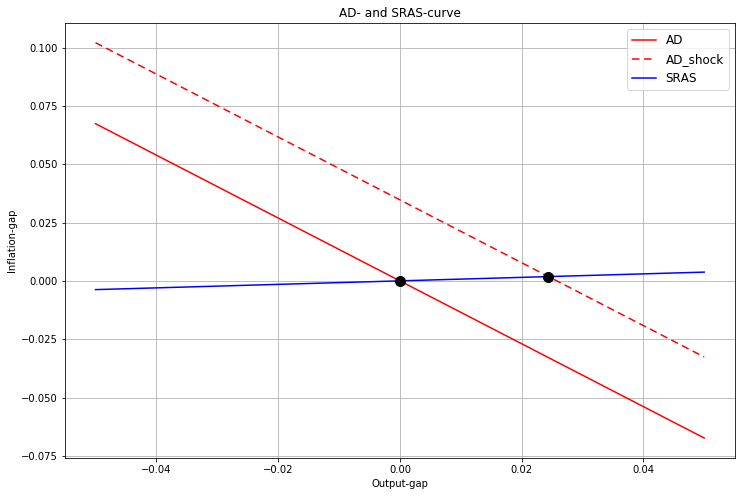

In [27]:
#Define span for y
y = np.linspace(-0.05,0.05)

#Define AD with and without shock and SRAS
AD = 1/(par['h']*par['alpha'])*(v_q2-(1+par['b']*par['alpha'])*y)
AD_shock = 1/(par['h']*par['alpha'])*(v_shock-(1+par['b']*par['alpha'])*y)
SRAS = pi1_q2+par['gamma']*y-par['phi']*par['gamma']*y1_q2+s_q2-par['phi']*s1_q2

#Setting up figure
plt.figure(figsize=(12,8))    
plt.xlabel("Output-gap")
plt.ylabel("Inflation-gap")
plt.grid()
plt.title("AD- and SRAS-curve")

#Plotting graphs
plt.plot(y, AD, label="AD", color="red")
plt.plot(y, AD_shock, label="AD_shock", color="red", dashes=[5,3])
plt.plot(y, SRAS, label="SRAS", color="blue")
plt.plot(y_q2, pi_q2, marker='o', color="black", markersize="10")
plt.plot(y_q2_shock, pi_q2_shock, marker='o', color="black", markersize="10")
plt.legend(loc="upper right", prop={'size':12})
plt.plot()

Thus, the positive demand disturbance causes an upward shift to the AD-curve, while the SRAS-curve is unaffected. The increased demand for goods results in an increase in those goods being supplied and thus an increase in the goods being traded. The final result is that the output- and inflation-gap become positive in period $t$ (same results as we derived above).

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

**Question 3: Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?**

We start by assigning values to the variables and parameters in this question

In [28]:
y1_q3 = 0
pi1_q3 = 0
s1_q3 = 0
v1_q3 = 0 # Demand disturbance from period -1. We need this to obtain the level of disturbance in period 0 
x = 0
x0 = 0.1
c = 0

We start by determining the number of periods in which we simulate our model after the demand shock occurs. We construct the AR(1) process of the demand disturbance in the following way:

a: we create an empty list of the demand disturbance, v_q3

b: we assign the value of the demand shock in period zero with the demand shock, x0, and the demand shock from the previous period, v1_q3=0.

c: we assign an AR(1) process to the demand disturbance for the remaining periods

In [29]:
# Periods
periods = 100

#Set up list
v_q3 = []
v_q3_init = par['delta']*v1_q3+x0
v_q3.append(v_q3_init)

#Define AR1
def v_func():
    """Defines a function which creates a list of values for the demand shock, v.

    Returns:
    
        v_q3[] (type: list) = A list of values (simulations) for the demand shock, v
        
    """
    for i in range(1,periods): 
        v_i = par['delta']*v_q3[i-1] + x
        v_q3.append(v_i)
v_func();

We now construct the AR(1) process for the supply disturbance. As there is no supply shock in period 0, we simulate the AR(1) process from period 0 and onwards

In [30]:
#Set up list
s_q3 = []

#Define AR1
def s_func():
    """Defines a function which creates a list of values for the supply shock, s.
     
    Returns:
    
        s_q3[] (type: list) = A list of values (simulations) for the supply shock, s.
        
    """
    for i in range(0,periods): 
        s_i = par['omega']*s1_q3+c
        s_q3.append(s_i)
s_func();

And now finally we define how y and $\pi$ is affected by the shocks

In [31]:
# Creates an empty list of the output- and inflation-gap, y_q3 and pi_q3
y_q3 = []
pi_q3 = []

# We use our lambda function and append the initival values of the variables and the parameters and apply
# insert shock functions evaluated in period 0 as well to the list of output- and inflation-gap
y_q3_init = y_func(v_q3[0], y1_q2, s_q3[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
y_q3.append(y_q3_init)

pi_q3_init = pi_func(v_q3[0], y1_q2, s_q3[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
pi_q3.append(pi_q3_init)

# We will now append the simulation for the remaining periods for the two variables
def q3(): 
    for i in range(1,periods):
        
        y_q3_sim = y_func(v_q3[i], y_q3[i-1], s_q3[i], s_q3[i-1], pi_q3[i-1], par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
        y_q3.append(y_q3_sim)
        
        pi_q3_sim = pi_func(v_q3[i], y_q3[i-1], s_q3[i], s_q3[i-1], pi_q3[i-1], par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
        pi_q3.append(pi_q3_sim)

q3();

And now we create a graph to show how the output- and inflation gap evolves after the demand shock

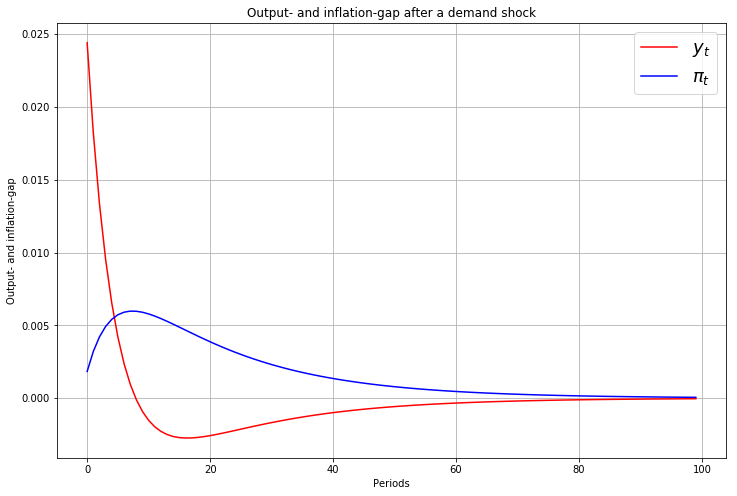

In [32]:
np.linspace(0,10)

plt.figure(figsize=(12,8))    
plt.plot(y_q3, label="$y_t$", color="red")
plt.plot(pi_q3, label="$\pi_t$", color="blue")
plt.xlabel("Periods")
plt.ylabel("Output- and inflation-gap")
plt.grid()
plt.title("Output- and inflation-gap after a demand shock")
    
plt.legend(loc="upper right", prop={'size':18})
plt.show();

From the graph above we see that the demand shock in period 0 increases both the output- and inflation gap in the first period under persistent demand disturbance. This is also what we expected, as the demand shock of $x_0=0.1$ implies that the demand disturbance will be $v_t=\delta v_{t-1}+x_0=0.1$. This is identical to the increase in demand disturbance of $v_t=0.1$ from question 2 (without persistent disturbance), where we observed both the output- and inflation gap to increase as well.

In the following periods, we see that the inflation-gap keeps increasing, but the output-gap is lowered. This is mainly because the SRAS-curve experiences an upward shift, as this curve is positively affected by the inflation-gap from the previous period. Thus, the suppliers of the economy will now sell their goods at a higher price than in the previous period and thereby increase the inflation-gap. The higher price level in the economy means that the buyers will demand less goods than in the previous period, and the output-gap falls as a result of that.

After a few periods, the output-gap becomes negative, as the inflation-gap keeps increasing. The negative output-gap forces the suppliers to lower there prices, and the inflation-gap becomes lower the next period. This dynamic continues for a number of periods, until the output- and inflation-gap is back at their equilirbium values. From the graph above it appears that they have reached their equilibrium values after approximately 100 periods, though they are still converging with infinitely small numbers after this.

Below we have created a graph to see how the demand disturbance, $v_t$, evolves after the demand shock occurs from $x_0$

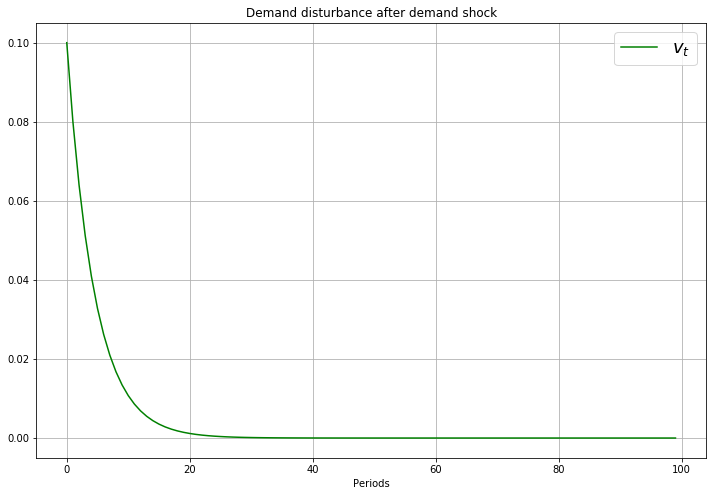

In [33]:
#Creating a graph to show how the demand disturbance evolves after a demand shock
np.linspace(0,10)

plt.figure(figsize=(12,8))    
plt.plot(v_q3, label="$v_t$", color="green")
plt.xlabel("Periods")
plt.grid()
plt.title("Demand disturbance after demand shock")
    
plt.legend(loc="upper right", prop={'size':18})
plt.show();

Due to the AR(1)-structure of the demand disturbance in this question, the demand shock of $x_0=0.1$ ensures that there will be a positive demand disturbance in the following periods. The effect of this shock vanishes over time, as we can see from the graph, and after approximately 30 periods, the demand disturbance is back to zero.

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [34]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4: Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:**

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

Creating the new shocks, which are stochastic and normally distributed. We use the seed number 1312.

In [35]:
seed = 1312
np.random.seed(seed)

# Defining the mean as zero for both the demand and supply shock
mu_x = 0
mu_c = 0

We now define the two types of shocks:

In [36]:
# Number of simulations used for this question
periods2 = 1000

# We create an empty list of the demand and supply disturbance, respectively. Again, we start by appending 
# the inital value in period 0 to both disturbances and thereafter run the simulation for the remaining
# periods.
v_q4 = []
v_q4_init = par['delta']*v1_q3+np.random.normal(mu_x, par['sigma_x'])
v_q4.append(v_q4_init)

def v_func2():
    """Defines a function which creates a list of values for the stochastic demand shock, v_stoch.
     
    Returns:
    
        v_q4[] (type: list) = A list of values (simulations) for the stochastic demand shock, v_shock.
        
    """
    for i in range(1,periods2): 
        v_q4_sim = par['delta']*v_q4[i-1] + np.random.normal(mu_x, par['sigma_x'])
        v_q4.append(v_q4_sim)
v_func2();


#Set up list and append initial value
s_q4 = []
s_q4_init = par['delta']*s1_q3+np.random.normal(mu_c, par['sigma_c'])
s_q4.append(s_q4_init)

#Simulate remaining periods
def s_func2():
    """Defines a function which creates a list of values for the stochastic supply shock, s_stoch.
     
    Returns:
    
        s_q4[] (list) = A list of values (simulations) for the stochastic supply shock, s_shock.
        
    """
    for i in range(1,periods2):
        s_q4_sim = par['omega']*s_q4[i-1] + np.random.normal(mu_c, par['sigma_c'])
        s_q4.append(s_q4_sim)
s_func2();

We now create a graph to show how the demand and supply disturbance evolves with stochastic shocks.

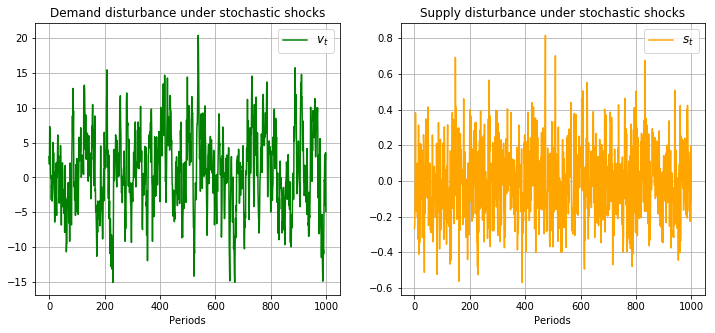

In [37]:
np.linspace(0,10)

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(v_q4, label="$v_t$", color="green")
plt.xlabel("Periods")
plt.grid()
plt.title("Demand disturbance under stochastic shocks")
plt.legend(loc="upper right", prop={'size':12})

ax2 = fig.add_subplot(1,2,2)
ax2.plot(s_q4, label="$s_t$", color="orange")
plt.xlabel("Periods")
plt.grid()
plt.title("Supply disturbance under stochastic shocks")

plt.legend(loc="upper right", prop={'size':12})
plt.show();

Now to get how y and $\pi$ reacts over time with these shocks, we define them with the same procedure as in question 2.3.

In [38]:
#Set up lists
y_q4 = []
pi_q4 = []

#Define initial values
y_q4_init = y_func(v_q4[0], y1_q2, s_q4[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
y_q4.append(y_q4_init)

pi_q4_init = pi_func(v_q4[0], y1_q2, s_q4[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
pi_q4.append(pi_q4_init)

#Simulate remaining periods
def q4(): 
    for i in range(1,periods2):
        
        #Output-gap
        y_q4_sim = y_func(v_q4[i], y_q4[i-1], s_q4[i], s_q4[i-1], pi_q4[i-1], par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
        y_q4.append(y_q4_sim)
        
        #Inflation-gap
        pi_q4_sim = pi_func(v_q4[i], y_q4[i-1], s_q4[i], s_q4[i-1], pi_q4[i-1], par['alpha'], par['h'], par['b'], par['phi'], par['gamma'])
        pi_q4.append(pi_q4_sim)

q4();

And we now plot the graphs of y and $\pi$ to show how the demand output- and inflation-gap evolves under stochastich shocks.

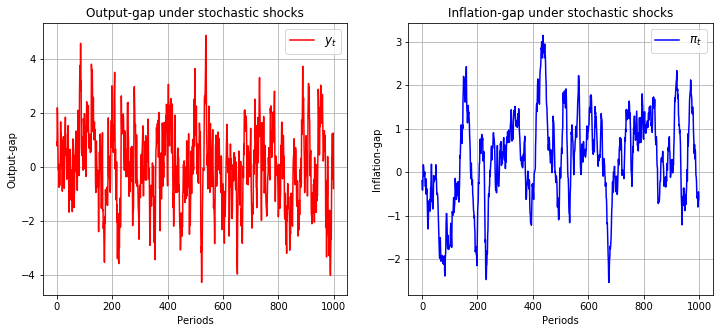

In [39]:
np.linspace(0,10)

fig2 = plt.figure(figsize=(12,5))

ax3 = fig2.add_subplot(1,2,1)
ax3.plot(y_q4, label="$y_t$", color="red")
plt.xlabel("Periods")
plt.ylabel("Output-gap")
plt.grid()
plt.title("Output-gap under stochastic shocks")
plt.legend(loc="upper right", prop={'size':12})

ax4 = fig2.add_subplot(1,2,2)
ax4.plot(pi_q4, label="$\pi_t$", color="blue")
plt.xlabel("Periods")
plt.ylabel("Inflation-gap")
plt.grid()
plt.title("Inflation-gap under stochastic shocks")
plt.legend(loc="upper right", prop={'size':12})

plt.show();

The graph above shows us how the output- and inflation-gap evolves for 1,000 periods under stochastic shocks. There seems to be a bit of persistence in the two variables, espcially for the inflation-gap. We recall from question 2.1 and the equilibrium values we found, that both the output- and inflation-gap are affected by the inflation-gap from the previous period (and the inflation-gap is affected the most). Thus, it doesn't come as a surprise to us, that the inflation-gap seems to be more persistent, which is also evident from this graph.

To round of this question, we find the relevant variances and correlations of the variables:

In [40]:
# Calculating the relevant statistics from this question
var_y = np.var(y_q4)
var_pi = np.var(pi_q4)
corr = np.corrcoef(y_q4,pi_q4)[0][1]
autocorr_y = np.corrcoef(y_q4[:-1], y_q4[1:])[0][1]
autocorr_pi = np.corrcoef(pi_q4[:-1], pi_q4[1:])[0][1]

# Printing those statistics
print(f'The variance of the output-gap is: {var_y}')
print(f'The variance of the inflation gap-is: {var_pi}')
print(f'The correlation coefficient between the output- and inflation gap is: {corr}')
print(f'The autocorrelation coefficient of the output-gap is: {autocorr_y}')
print(f'The autocorrelation coefficient of the inflation-gap is: {autocorr_pi}')

The variance of the output-gap is: 2.08932426343148
The variance of the inflation gap-is: 1.0781079782111642
The correlation coefficient between the output- and inflation gap is: -0.255093121771392
The autocorrelation coefficient of the output-gap is: 0.7999979829233075
The autocorrelation coefficient of the inflation-gap is: 0.9780616485832612


**Question 5: Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31.**

We create a function with a variable named q, which we will assign to the parameter of phi. Again we use our lambda function, append the initival values and simulate for the rest of the period. 

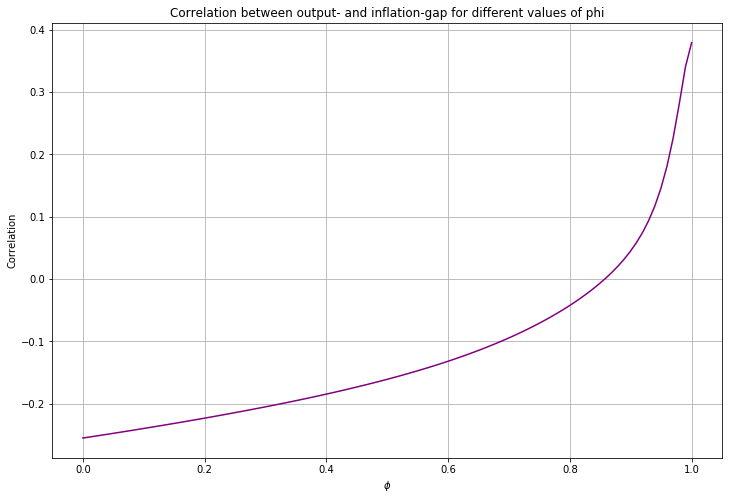

In [41]:
def q5(q):
    """Defines a function which creates a list of values for the stochastic supply shock, s_stoch.
    
    Args:
        
        q (type: float) = The variable we assign to phi.
    
    Returns:
    
        np.corrcoef(y_q5,pi_q5)[0,1] (type: float) = The correlation coefficient between the output- and
        inflation-gap.
        
    """
    y_q5 = []
    pi_q5 = []
    
    y_q5_init = y_func(v_q4[0], y1_q2, s_q4[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], q, par['gamma'])
    y_q5.append(y_q5_init)
    
    pi_q5_init = pi_func(v_q4[0], y1_q2, s_q4[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], q, par['gamma'])
    pi_q5.append(pi_q5_init)
    
    for i in range(1,periods2): 
        
        #Output-gap
        y_q5_sim = y_func(v_q4[i], y_q5[i-1], s_q4[i], s_q4[i-1], pi_q5[i-1], par['alpha'], par['h'], par['b'], q, par['gamma'])
        y_q5.append(y_q5_sim)
        
        #Inflation-gap
        pi_q5_sim = pi_func(v_q4[i], y_q5[i-1], s_q4[i], s_q4[i-1], pi_q5[i-1], par['alpha'], par['h'], par['b'], q, par['gamma'])
        pi_q5.append(pi_q5_sim)
        
    return np.corrcoef(y_q5,pi_q5)[0,1]

#We now create a graph to illustrate how the correlation varies for different values of phi
x = np.linspace(0,1,100)
corr = np.empty(100)
for i,X in enumerate(x):
    corr[i] = q5(X)

plt.figure(figsize=(12,8))    
plt.plot(x, corr, color="purple")
plt.title('Correlation between output- and inflation-gap for different values of phi')
plt.xlabel('$\phi$')
plt.ylabel('Correlation')
plt.grid()
plt.show()

We will now derive the approximate value of phi which results in a correlation coefficient of 0.31 by applying a numerical optimizer defined below.

In [42]:

def optimizer(x):
    """Defines a function which creates a list of values for the simulations of the output- and
         inflation-gap.
    
    Args: 
        
        x (type: float) = The value of phi.
     
    Returns:
    
        (phi(x)-0.31)**2 (type: float) = The squared residual of the correlation coefficent between the output-
        and inflation-gap for an arbitrary value of phi and the correlation coefficient between the output-
        and inflation-gap for US data (0.31).
        
    """ 
    return (q5(x)-0.31)**2

res = optimize.minimize_scalar(optimizer, bounds=(0, 1), method='bounded')
print(f'The phi value that approximately results in a correlation of 0.31 between the output- and inflation gap is: {res.x:.4f}')

The phi value that approximately results in a correlation of 0.31 between the output- and inflation gap is: 0.9846


To check this result we insert the optimal phi value found above and check the associated correlation:

In [43]:
q5(res.x)

From the graph above we see that the correlation between the output- and inflation-gap is increasing in $\phi \in (0,1)$. From the results derived above, we see that $\phi \approx 0.98$ approximately equals a correlation of 0.31 between the output- and inflation-gap.

**Quesiton 6: Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:**

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

We start by defining the variables that fit the US data

In [44]:
var_y_USdata = 1.64
var_pi_USdata = 0.21
corr_y_pi_USdata = 0.31
autocorr_y_USdata = 0.84
autocorr_pi_USdata = 0.48

And now define a function that calculates variances, correlations and autocorrelations of $y$ and $\pi$ based on different parameter value inputs:

In [45]:
def q6(parameters):
    """Defines a function that applies the simulations of the demand disturbance, supply disturbance,
       output- and inflation-gap. 
    
    Args: 
        
        parameters (type: list,float) = A 1x3 vector of the value of each parameter that we want to optimize in this
                                   question, that is sigma_x, sigma_c and phi.
     
    Returns:
    
        var_y_q6 (type: float) = The variance of the output-gap in the economy given the parameter values.
        var_pi_q6 (type: float) = The variance of the output-gap in the economy given the parameter values.
        corr_q6 (type: float) = The correlation coefficient between the output-gap and the inflation-gap in
                                the economy given the parameter values.
        autocorr_y_q6 (type: float) = The autocorrelation coefficient of the output-gap in the economy given
                                      the parameter values.
        autocorr_pi_q6 (type: float) = The autocorrelation coefficient of the inflation-gap in the economy 
                                       given the parameter values.
        
    """ 
    # We set the seednumber to the same as before, but since we draw our number in a different order, the result wont be the same, but we still do this in order to get the same result every time we run the code.
    np.random.seed(seed)     
    
    # We then create an empty array for s_t, v_t, pi_star and y_star. And we the append the starting value.
    v_q6 = []
    v_start_q6 = par['delta']*v_q2 + np.random.normal(0,parameters[0])
    v_q6.append(v_start_q6)
    
    s_q6 = []
    s_start_q6 = par['omega']*s_q2 + np.random.normal(0,parameters[1])
    s_q6.append(s_start_q6)
    
    y_q6 = []
    y_start_q6 = y_func(v_q6[0], y1_q2, s_q6[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], parameters[2], par['gamma'])
    y_q6.append(y_start_q6)
    
    pi_q6 = []
    pi_start_q6 = pi_func(v_q6[0], y1_q2, s_q6[0], s1_q2, pi1_q2, par['alpha'], par['h'], par['b'], parameters[2], par['gamma'])
    pi_q6.append(pi_start_q6)
    
    # Next we make a loop that append the last 999 values, which is the same process as earlier.
    for i in range(1,1000):
        v_q6_i = par['delta']*v_q6[i-1]+np.random.normal(0,parameters[0])
        v_q6.append(v_q6_i)
        
        s_q6_i = par['omega']*s_q6[i-1]+np.random.normal(0,parameters[1])
        s_q6.append(s_q6_i)
        
        y_q6_i = y_func(v_q6[i], y_q6[i-1], s_q6[i], s_q6[i-1], pi_q6[i-1], par['alpha'], par['h'], par['b'], parameters[2], par['gamma'])
        y_q6.append(y_q6_i)
        
        pi_q6_i = pi_func(v_q6[i], y_q6[i-1], s_q6[i], s_q6[i-1], pi_q6[i-1], par['alpha'], par['h'], par['b'], parameters[2], par['gamma'])
        pi_q6.append(pi_q6_i)
    
    var_y_q6 = np.var(y_q6)
    var_pi_q6 = np.var(pi_q6)
    corr_q6 = np.corrcoef(y_q6,pi_q6)[0][1]
    autocorr_y_q6 = np.corrcoef(y_q6[:-1], y_q6[1:])[0][1]
    autocorr_pi_q6 = np.corrcoef(pi_q6[:-1], pi_q6[1:])[0][1]

    return  var_y_q6,var_pi_q6,corr_q6,autocorr_y_q6,autocorr_pi_q6
    

And define a function that finds the summed squared residuals between the calculated variances, correlations and autocorrelations (all just weighted with their size, which should be okay as they are fairly similar in size).   

In [46]:
def squared_resid(parameters):
    """Defines a function of vectors for the squared residuals of the statistics.
    
    Args: 
        
        parameters (type: list, float) = A 1x3 vector containing the value of each parameter that we want to optimize in this
                                   question, that is sigma_x, sigma_c and phi.
     
    Returns:
    
        sum_squared_res (type: float) = The sum of all the squared residuals
        
    """ 
    q6_vec = q6(parameters)
    
    diff_var_y_q6 = (q6_vec[0]-var_y_USdata)**2
    diff_var_pi_q6 = (q6_vec[1]-var_pi_USdata)**2
    diff_corr_y_pi_q6 = (q6_vec[2]-corr_y_pi_USdata)**2
    diff_autocorr_y_q6 = (q6_vec[3]-autocorr_y_USdata)**2
    diff_autocorr_pi_q6 = (q6_vec[4]-autocorr_pi_USdata)**2
    
    sum_squared_res = diff_var_y_q6+diff_var_pi_q6+diff_corr_y_pi_q6+diff_autocorr_y_q6+diff_autocorr_pi_q6
    
    return sum_squared_res


We will now optimize the three parameters values, $\sigma_x^2$, $\sigma_c^2$ and $\phi$. We will use the optimizer function from the scipy package. To do se, we need to assign some initial guesses for the values of these parameters (we use the current parameter values given for $\sigma_x^2$ and $\sigma_c^2$ and the optimal value of $\phi$, which we found in the previous question). With these quesses we simply try to minimize the squared_resid function from above.

In [47]:
guess = (par['sigma_x'], par['sigma_c'], 0.9846)

result_q6 = optimize.minimize(squared_resid, guess, method='Nelder-Mead')
result_q6_vec = result_q6.x

print(f'Following this optimization we find the values sigma_x={result_q6.x[0]:.3f}, sigma_c={result_q6.x[1]:.3f} and phi={result_q6.x[2]:.3f}')

Following this optimization we find the values sigma_x=3.062, sigma_c=0.219 and phi=0.955


We will now apply these parameter values to see which value our statistics will have and how much they differ from the date of the US economy.

In [48]:
print('Given the optimal values of the parameters we get:')
print(f'- a variance of the output-gap of: {q6(result_q6_vec)[0]:.4f}')
print(f'- a variance of the inflation-gap of: {q6(result_q6_vec)[1]:.4f}')
print(f'- a correlation coefficient between the output- and inflation-gap of: {q6(result_q6_vec)[2]:.4f}') 
print(f'- an autocorrelation coefficient for the output-gap of: {q6(result_q6_vec)[3]:.4f}') 
print(f'- an autocorrelation coefficient for the inflation-gap of: {q6(result_q6_vec)[4]:.4f}')

Given the optimal values of the parameters we get:
- a variance of the output-gap of: 1.6461
- a variance of the inflation-gap of: 0.0721
- a correlation coefficient between the output- and inflation-gap of: 0.2718
- an autocorrelation coefficient for the output-gap of: 0.8020
- an autocorrelation coefficient for the inflation-gap of: 0.4886


Thus, we see that our values of $var(y_t)$, $corr(y_t,\pi_t)$, $corr(y_t,y_{t-1})$ and $corr(\pi_t,\pi_{t-1})$ come fairly close to the equivalent US data. However, our value of $var(\pi_t)$ deviates significantly from the US data, as we obtain a variance of .07, while that of the US data is 0.21. 

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [49]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1: Plot the histograms of the budget shares for each good across agents.**

We plot the histogram of the budget shares, $\beta$, as follows. 

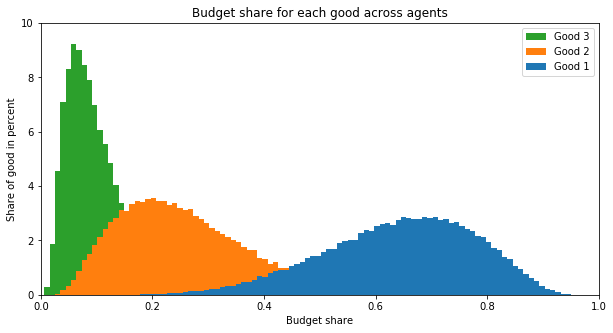

In [50]:
#Set up figure
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim([0,10]) # Setting boundaries for y-axis
ax.set_xlim([0,1]) # Setting boundaries for x-axis

#Draw histogram
ax.hist(betas,bins=100,density=True,histtype='stepfilled')

#Add titles and labels
plt.title("Budget share for each good across agents") #Adding title
plt.xlabel("Budget share") #Labelling x-axis
plt.ylabel("Share of good in percent") #Labelling y-axis
plt.legend(('Good 3', 'Good 2', 'Good 1')) #Adding legend

We see from this histogram that good 1 has the highest average budget share and good 3 the lowest, indicating that the demand for good one should be the highest, good 3 should be the lowest and good 2 in between. This, we expect, will be reflected in the relative prices, which we will investigate later. 

We will now define the individual beta-values as follows and calculate the values of the mean to check if they correspond with the picture given from the graph above:

In [51]:
#Define betas individually
betas1 = [item[0] for item in betas]
betas2 = [item[1] for item in betas]
betas3 = [item[2] for item in betas]

#Define as np.arrays
beta_good1 = np.array(betas1)
beta_good2 = np.array(betas2)
beta_good3 = np.array(betas3)

#Calculate and print means
means = (np.mean(beta_good1), np.mean(beta_good2), np.mean(beta_good3))
means

As seen on these means, they correspond well with the graph having the highest mean of $64\%$ on good one, the lowest of $10\%$ on good three and the in between value of $26\%$ on good two.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2: Plot the excess demand functions.**

To get to the excess demand functions, we start by defining the demand functions for good one and good two as follows:

In [52]:
#Define the three demand functions
def demand1(beta,p1,p2,e1,e2,e3):
    """
    Calculates demand for good 1
    
    Args:
        beta (numpy.ndarray): Budget share of good 1
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        
    Returns:
        Demand for good 1
    """   
    I = p1*e1+p2*e2+e3
    return beta*I/p1

def demand2(beta,p1,p2,e1,e2,e3):
    """
    Calculates demand for good 2
    
    Args:
        beta (numpy.ndarray): budget share of good 2
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        
    Returns:
        Demand for good 2
    """   
    I = p1*e1+p2*e2+e3
    return beta*I/p2

def demand3(beta,p1,p2,e1,e2,e3):
    """
    Calculates demand for good 3
    
    Args:
        beta (numpy.ndarray): budget share of good 3
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        
    Returns:
        Demand (float) for good 3
    """   
    I = p1*e1+p2*e2+e3
    return beta*I

Having defined the demand functions, we can now define the excess demand functions by adding all demand together and subtracting the total supply (endowments) of the supply from it. This is done with both goods. 

In [53]:
def excess_demand1(beta,p1,p2,e1,e2,e3):
    """
    Calculates excess demand for good 1
    
    Args:
        beta (float): budget share of good 1
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (float): Owned units of good 1
        e2 (float): Owned units of good 2
        e3 (float): Owned units of good 3
        
    Returns:
        Excess demand (float) for good 1
    """ 
    demand = np.sum(demand1(beta,p1,p2,e1,e2,e3))
    supply = np.sum(e1)
    excess = demand-supply
    return excess

def excess_demand2(beta,p1,p2,e1,e2,e3):
    """
    Calculates excess demand for good 2
    
    Args:
        beta (float): budget share of good 2
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        
    Returns:
        Excess demand (float) for good 2
    """   
    demand = np.sum(demand2(beta,p1,p2,e1,e2,e3))
    supply = np.sum(e2)
    excess = demand-supply
    return excess

def excess_demand3(beta,p1,p2,e1,e2,e3):
    """
    Calculates excess demand for good 3
    
    Args:
        beta (float): budget share of good 2
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        
    Returns:
        Excess demand (float) for good 3
    """   
    demand = np.sum(demand3(beta,p1,p2,e1,e2,e3))
    supply = np.sum(e3)
    excess = demand-supply
    return excess

Now we want to plot these two excess demand functions, which relies on the prices of both goods, requiring two three-dimensional graphs. We start by setting the number of elements and the span of the prices, then we create two empty numpy arrays and finally we loop over all the prices, filling the arrays. 

In [54]:
#Setup 
N2 = 50
p1_span = np.linspace(0.1,7,N2)
p2_span = np.linspace(0.1,3,N2)

#Initialize numpy arrays
excess_1_graph = np.empty((N2,N2))
excess_2_graph = np.empty((N2,N2))
excess_3_graph = np.empty((N2,N2))

#Fill up numpy arrays
p1_graph, p2_graph = np.meshgrid(p1_span, p2_span,indexing='ij') 
for i,p1 in enumerate(p1_span):
    for j,p2 in enumerate(p2_span):
        excess_1_graph[i,j] = excess_demand1(beta_good1,p1,p2,e1,e2,e3)
        excess_2_graph[i,j] = excess_demand2(beta_good2,p1,p2,e1,e2,e3)
        excess_3_graph[i,j] = excess_demand3(beta_good3,p1,p2,e1,e2,e3)

Now we have the data to fill the graphs. First we plot the excess demand for good one below:

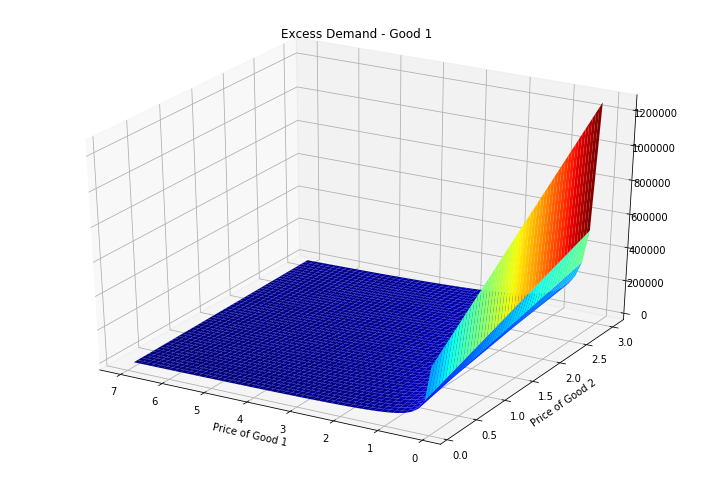

In [55]:
#Set up figure
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1, projection='3d')

#Plot graph
ax.plot_surface(p1_graph,p2_graph,excess_1_graph,cmap=cm.jet)

#Layout for graph
ax.invert_xaxis()
ax.set_title('Excess Demand - Good 1')
ax.set_xlabel('Price of Good 1')
ax.set_ylabel('Price of Good 2')
fig.tight_layout()

And now we plot the excess demand for good two:

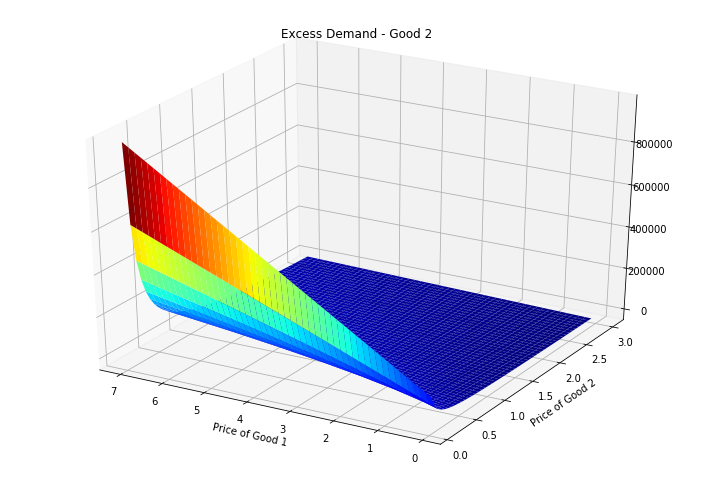

In [56]:
#Set up figure
fig = plt.figure(figsize=(10,20))
ax2 = fig.add_subplot(3,1,1, projection='3d')

#Plot graphs
ax2.plot_surface(p1_graph,p2_graph,excess_2_graph,cmap=cm.jet)

#Layout for graph
ax2.invert_xaxis()
ax2.set_title('Excess Demand - Good 2')
ax2.set_xlabel('Price of Good 1')
ax2.set_ylabel('Price of Good 2')
fig.tight_layout()

And finally we plot the excess demand for good 3:

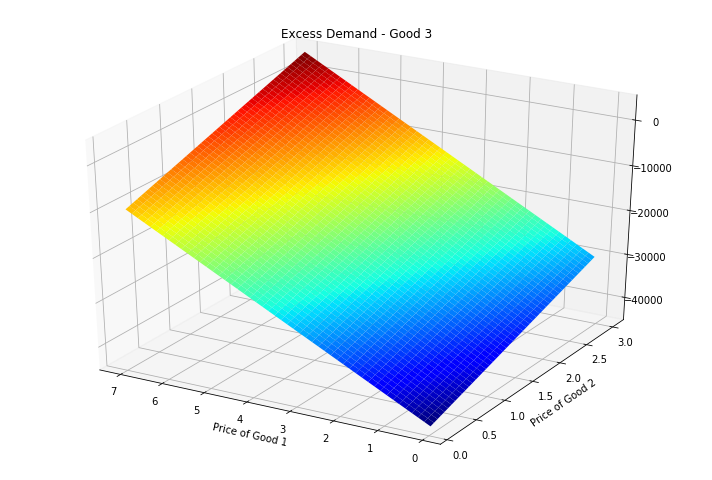

In [57]:
#Set up figure
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1, projection='3d')

#Plot graph
ax.plot_surface(p1_graph,p2_graph,excess_3_graph,cmap=cm.jet)

#Layout for graph
ax.invert_xaxis()
ax.set_title('Excess Demand - Good 3')
ax.set_xlabel('Price of Good 1')
ax.set_ylabel('Price of Good 2')
fig.tight_layout()

We see from the first two graphs that decreases for the given good, when its price is falling as well as when the price of the other good is increasing. When the price of the good is relatively high, you simply demand more of the other good, which creates this excess demand. For good 3 we see that for most prices in the chosen span of the relative prices for good 1 and 2, there is actually a negative excess demand. This is simply due to the fact that for these prices, the budget share, $\beta$, of good 3 is too low for the consumers to want it, and they will therefore rather sell that good to buy more of the other goods, effectively creating this negative excess demand. However, for sufficiently high prices of good 1 and 2, the excess demand of good 3 becomes positive.

**Quesiton 3: Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:**

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

To first make a guess on the size of $p_1$ and $p_2$ we look at the means found in Question 1. We see that the budget share of good one is *approximately* three times larger than that of good two, whereas the budget share of good two is *approximately* two times larger than the numeraire good three. We therefore choose to guess on the prices $p_2$=2 and $p_1$=6. We choose the tolerance to be $\epsilon = 1*10^{-8}$ and the adjusment aggressivity parameter to be $\kappa = 0.1$.

In [58]:
#Set prices and parameters
p1 = 6
p2 = 2
epsilon = 1e-8
kappa = 0.1

#Define function for finding equilibrium
def find_equi(beta_good1,beta_good2,p1,p2,e1,e2,e3):
    """
    Find the Walras equilibrium prices by minimizing the excess demand through a tatonnement process
    
    Args:
        beta_good1 (numpy.ndarray): Contains all beta values (budget shares) for good 1
        beta_good2 (numpy.ndarray): Contains all beta values (budget shares) for good 2
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        
    Returns:
        p1 (float) Walras equilibrium price for good 1
        p2 (float) Walras equilibrium price for good 2
    """   
    #Initialize
    t=0
    maxiter=10000
    
    #Start process
    while True:
        Z1 = excess_demand1(beta_good1,p1,p2,e1,e2,e3)
        Z2 = excess_demand2(beta_good2,p1,p2,e1,e2,e3)
        
        if  np.abs(Z1) < epsilon and np.abs(Z2) < epsilon or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:.8f} -> excess demand -> {Z1:.8f}')  
            print(f'{t:3d}: p2 = {p2:.8f} -> excess demand -> {Z2:.8f}') 
            break
            
        else:
        # c. step 3: update p1 and p2
            p1 = p1 + kappa*Z1/N
            p2 = p2 + kappa*Z2/N
        
        t += 1    

    return p1, p2

We now put our known values into the above-defined function to get the Walras equilibrium prices. This yields: 

In [59]:
#Find prices and print
p1,p2 = find_equi(beta_good1,beta_good2,p1,p2,e1,e2,e3)
p1,p2

10000: p1 = 6.49005514 -> excess demand -> 0.00000597
10000: p2 = 2.61669400 -> excess demand -> 0.00000223


Hereby, we find the prices to be $p_1=6.49$ and $p_2=2.62$ in the Walras equilibrium. 

**Question 4: Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.**

To get the utilities we insert the equilibrium prices in the three demand function defined earlier. This gives us the amount of each good that each person will buy - from this we can calculate each of their utilities. We start by defining a utility function in which the equilibrium prices can be plugged in:

In [60]:
def util(p1,p2,e1,e2,e3,beta1,beta2,beta3,gamma):
    """
    Calculates utility for the consumer based on units of goods and values of beta and gamma
    
    Args:
        p1 (float): Relative price of good 1
        p2 (float): Relative price of good 2
        e1 (numpy.ndarray): Owned units of good 1
        e2 (numpy.ndarray): Owned units of good 2
        e3 (numpy.ndarray): Owned units of good 3
        beta1 (numpy.ndarray): budget share of good 1
        beta2 (numpy.ndarray): budget share of good 2
        beta3 (numpy.ndarray): budget share of good 3
        gamma (float): Exponentiality of the utility function
        
    Returns:
        Utility (numpy.ndarray) of goods based on values of beta and gamma
    """   
    #Define goods
    good1 = demand1(beta1,p1,p2,e1,e2,e3)
    good2 = demand2(beta2,p1,p2,e1,e2,e3)
    good3 = demand3(beta3,p1,p2,e1,e2,e3)
    
    #Calculate utility
    utility = (good1**beta1+good2**beta2+good3**beta3)**gamma
    return utility

In [61]:
utility_graph = util(p1,p2,e1,e2,e3,beta_good1,beta_good2,beta_good3,gamma)

We now plot a histogram showing the distribution of utilities. 

Text(0, 0.5, 'Number of buyers')

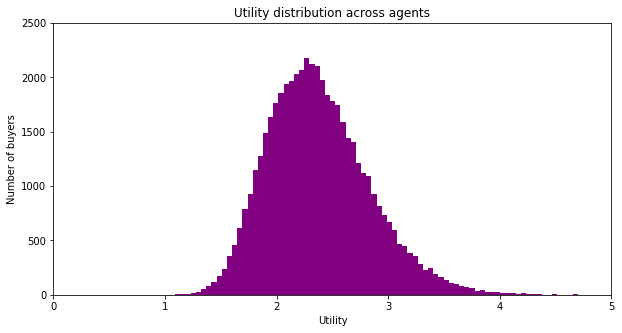

In [62]:
#Set up figure
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim([0,2500]) # Setting boundaries for y-axis
ax.set_xlim([0,5]) # Setting boundaries for x-axis

#Plot graph
ax.hist(utility_graph,bins=100,density=False,histtype='stepfilled', color='Purple')

#Add titles and labels
plt.title("Utility distribution across agents") #Adding title
plt.xlabel("Utility") #Labelling x-axis
plt.ylabel("Number of buyers") #Labelling y-axis

And finally we find the mean and variance of the utility distribution as follows:

In [63]:
#Calculate mean and variance of utility
meanvar = (np.mean(utility_graph),np.var(utility_graph))
meanvar

We see that the mean of the utility distribution is $2.38$ - which corresponds with what is shown in the graph above - while the variance is found to be $0.21$.

**Question 5: Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?**

We start by defining the new endowments, where everyone now gets exactly one unit of each good intially. 

In [64]:
#Define new equally distributed endowments
e1_new = np.full((N),1)
e2_new = np.full((N),1)
e3_new = np.full((N),1)

We now want to find the Walras equilibrium prices, which we do with the find_equi-function from Question 3. We use the same initial for the prices as before. This yields:

In [65]:
#Price guesses
p1_new=6
p2_new=2

#Find and print new Walras equilibrium prices
p1_new,p2_new = find_equi(beta_good1,beta_good2,p1_new,p2_new,e1_new,e2_new,e3_new)
p1_new,p2_new

10000: p1 = 6.44732665 -> excess demand -> 0.00000468
10000: p2 = 2.59082036 -> excess demand -> 0.00000174


Thus, we find $p_1^{new}=6.45$ and $p_2^{new}=2.59$, which is approximately the same prices as before.

To now look at the distribution of the utilities, we get the new utilities from the slightly different prices and these are plotted:

In [66]:
utility_graph2 = util(p1_new,p2_new,e1_new,e2_new,e3_new,beta_good1,beta_good2,beta_good3,gamma)

Text(0, 0.5, 'Share of buyers')

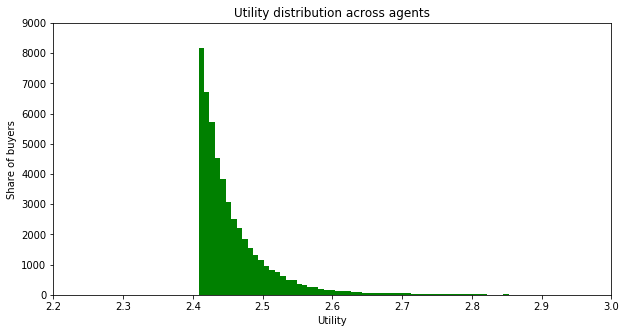

In [67]:
#Set up figure
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim([0,9000]) # Setting boundaries for y-axis
ax.set_xlim([2.2,3]) # Setting boundaries for x-axis

#Plot graph
ax.hist(utility_graph2,bins=100,density=False,histtype='stepfilled', color='Green')

#Add titles and labels
plt.title("Utility distribution across agents") 
plt.xlabel("Utility") 
plt.ylabel("Share of buyers") 

From this graph we see that the equal initial distribution of the endowments, sets a lower bound on the utility of the buyers, as they can no longer be randomly assigned to have almost no endowments. On the other hand, we dont see as high levels of utility as before either, as one can't be lucky and have a lot of initial endowments either. Now to calculate the mean and variance:

In [68]:
#Calculate mean and variance
meanvar2 = (np.mean(utility_graph2),np.var(utility_graph2))
meanvar2

To support the claims made above, we see that the variance is much smaller in this case with equal endowments as it is now only $0.0036$ compared to the variance of $0.20789$ from before. From an equality-focusing point of view, this second case is therefore interesting. Also when we look at the mean values, this second example is better with a mean utility value of $2.46$ compared to the $2.38$ from the earlier example. 

In [71]:
def PlotGraph(p1,p1_new,p2,p2_new,e1,e1_new,e2,e2_new,e3,e3_new,beta_good1,beta_good2,beta_good3,gamma):
    """
    This function is able to plot the graphs of the two cases with different endowments. 
    Will be used later to plot the graphs allowing gamma to vary.
    
    Args:
        p1 (float): Former relative price of good 1
        p1_new (float): New relative price of good 1
        p2 (float): Former relative price of good 2
        p2_new (float): New relative price of good 2
        e1 (numpy.ndarray): Former endowments of good 1
        e1_new (numpy.ndarray): New endowments of good 1
        e2 (numpy.ndarray): Former endowments of good 2
        e2_new (numpy.ndarray): New endowments of good 2
        e3 (numpy.ndarray): Former endowments of good 3
        e3_new (numpy.ndarray): New endowments of good 3
        beta_good1 (float): budget share of good 1
        beta_good2 (float): budget share of good 2
        beta_good3 (float): budget share of good 3
        gamma (float): Exponentiality of the utility function
        
    Returns:
        Plots two graph with different initial endowments
    """   
    
    #First we define the lists containing utilities
    u1 = util(p1,p2,e1,e2,e3,beta_good1,beta_good2,beta_good3,gamma)
    u2 = util(p1_new,p2_new,e1_new,e2_new,e3_new,beta_good1,beta_good2,beta_good3,gamma)
    
    #Calculate means and variances as extra information in graph
    meanu1 = round(np.mean(u1),2)
    mean1string = ' Mean='+str(meanu1)
    varu1 = round(np.var(u1),3)
    var1string = ' Var='+str(varu1)
    
    meanu2 = round(np.mean(u2),2)
    mean2string = ' Mean='+str(meanu2)
    varu2 = round(np.var(u2),3)
    var2string = ' Var='+str(varu2)

    #Plot the two graphs
    fig2 = plt.figure(figsize=(12,5))
    ax2 = fig2.add_subplot(1,2,1)
    ax2.hist(u1, bins=100, density=False, color='Red') #Plotting and labelling demand function 
    plt.title("Utility distribution with random initial endowments") #Adding title
    plt.xlabel("Utility") #Labelling x-axis
    plt.ylabel("Number of buyers") #Labelling y-axis
    plt.axvline(x=meanu1,color='black') #Adds a vertical black line at the mean
    plt.text(meanu1,1000,mean1string+var1string) #Adds the text containing values of mean and variance
    
    ax3 = fig2.add_subplot(1,2,2)
    ax3.hist(u2, bins=100, density=False, color='Red') #Plotting and labelling demand function
    plt.title("Utility distribution with equal initial endowments") #Adding title
    plt.xlabel("Utility") #Labelling x-axis
    plt.axvline(x=meanu2,color='black')
    plt.text(meanu2,3000,mean2string+var2string)

#Plots the graph (using the function Plotgraph) and adds a slider to adjust the value of gamma. 
widgets.interact(PlotGraph,p1=widgets.fixed(p1),p1_new=widgets.fixed(p1_new), p2=widgets.fixed(p2), 
                 p2_new=widgets.fixed(p2_new),e1=widgets.fixed(e1),e1_new=widgets.fixed(e1_new), e2=widgets.fixed(e2),
                 e2_new=widgets.fixed(e2_new), e3=widgets.fixed(e3), e3_new=widgets.fixed(e3_new),
                 beta_good1=widgets.fixed(beta_good1),beta_good2=widgets.fixed(beta_good2), 
                 beta_good3=widgets.fixed(beta_good3),
                 gamma=widgets.FloatSlider(description="$\gamma$", min=0.0, max=4 , step=0.05, value=0.8))

interactive(children=(FloatSlider(value=0.8, description='$\\gamma$', max=4.0, step=0.05), Output()), _dom_cla…

<function __main__.PlotGraph(p1, p1_new, p2, p2_new, e1, e1_new, e2, e2_new, e3, e3_new, beta_good1, beta_good2, beta_good3, gamma)>

From the two graphs we see that the conclusion wrt. the mean does in fact change for higher values of $\gamma$ due to the exponential nature of the utility function. The mean is higher for the case with randomly assigned endowments when $\gamma$ is higher than around $2.3$. However, it is clear that the variance is still much smaller in equally distributed endowments case, and this is only more pronounced for higher values of $\gamma$. Conversely, the difference in variance between the two cases decreases, when $\gamma$ decreases. 